In [1]:
import glob
import os
import matplotlib.pyplot as plt
from osgeo import gdal
from osgeo import ogr
from osgeo import osr

import numpy as np

In [16]:

def reproject_image(source_img, target_img, clip_shapefile = None, no_data_val = 0):

    s = gdal.Open(source_img)
    geo_s = s.GetGeoTransform()
    s_x_size, s_y_size = s.RasterXSize, s.RasterYSize
    s_xmin = min(geo_s[0], geo_s[0] + s_x_size * geo_s[1])
    s_xmax = max(geo_s[0], geo_s[0] + s_x_size * geo_s[1])
    s_ymin = min(geo_s[3], geo_s[3] + s_y_size * geo_s[5])
    s_ymax = max(geo_s[3], geo_s[3] + s_y_size * geo_s[5])
    s_xRes, s_yRes = abs(geo_s[1]), abs(geo_s[5])
    if type(target_img) == str:
        t = gdal.Open(target_img)    
    else:
        t = target_img
    geo_t = t.GetGeoTransform()
    x_size, y_size = t.RasterXSize, t.RasterYSize
    xmin = min(geo_t[0], geo_t[0] + x_size * geo_t[1])
    xmax = max(geo_t[0], geo_t[0] + x_size * geo_t[1])
    ymin = min(geo_t[3], geo_t[3] + y_size * geo_t[5])
    ymax = max(geo_t[3], geo_t[3] + y_size * geo_t[5])
    xRes, yRes = abs(geo_t[1]), abs(geo_t[5])
    if (s_x_size == x_size) & (s_y_size == y_size) & \
       (s_xmin == xmin) & (s_ymin == ymin) & \
       (s_xmax == xmax) & (s_ymax == ymax) & \
       (s_xRes == xRes) & (s_yRes == yRes):

        if clip_shapefile is not None:

            g = gdal.Warp('', source_img, format='MEM',
                        cutlineDSName=clip_shapefile,
                        cropToCutline=False,
                        dstNodata = no_data_val)
        else:
            g = gdal.Open(source_img)
    else:
        dstSRS = osr.SpatialReference()
        raster_wkt = t.GetProjection()
        dstSRS.ImportFromWkt(raster_wkt)

        if clip_shapefile is not None:

            g = gdal.Warp('', source_img, format='MEM',
                      outputBounds=[xmin, ymin, xmax, ymax], xRes=xRes, yRes=yRes,
                      dstSRS=dstSRS, cutlineDSName=clip_shapefile,
                      cropToCutline=False,
                      dstNodata = no_data_val)
        else:
            g = gdal.Warp('', source_img, format='MEM',
                      outputBounds=[xmin, ymin, xmax, ymax], xRes=xRes, yRes=yRes,
                       dstSRS=dstSRS)
    return g    

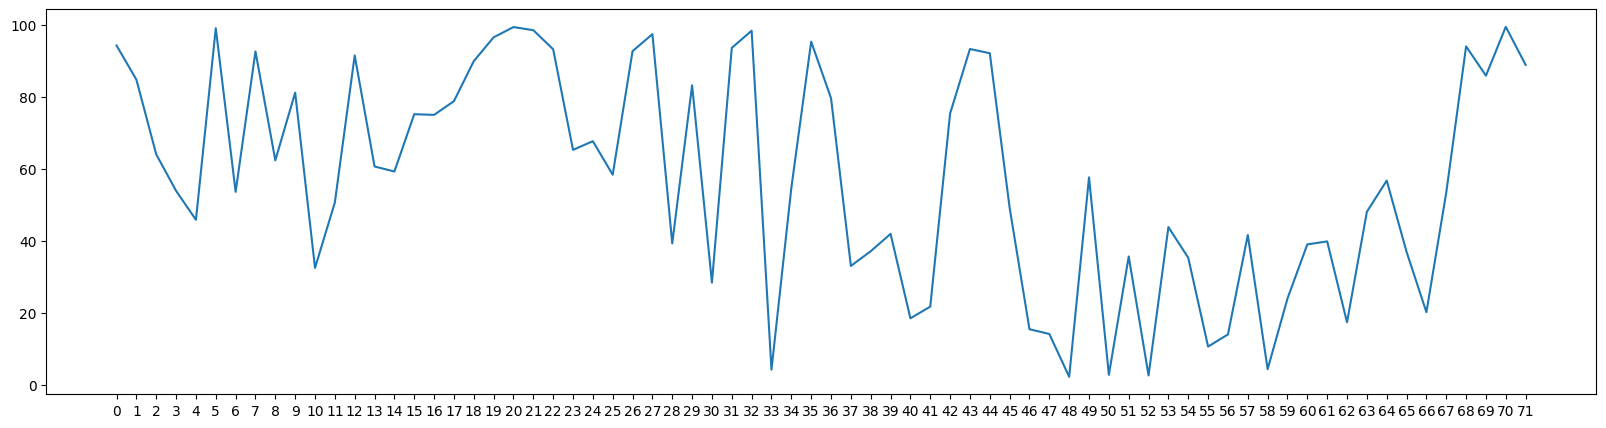

In [17]:
# establish which year to classify
year = 2019

# find the files related to that year
flist = sorted(glob.glob('/data/EO4ASGM/EO4ASGM_S2_SR_EO4ASGM_%s*'%year))

# open the file that has the probability handle
ma_opn = gdal.Open([i for i in flist if 'probability' in i][0])
ma_arr = ma_opn.ReadAsArray()

# plot the average cloud probability 
plt.figure(figsize=(20,5))
plt.plot(np.nanmean(ma_arr,axis=(1,2)))
_ = plt.xticks(range(ma_arr.shape[0]))
# step 48 has very few clouds - lets plot that!

In [3]:
# open the Band 2 file
b2_opn = gdal.Open('/data/EO4ASGM/EO4ASGM_S2_SR_EO4ASGM_%s_B2.tif'%year)
# open layer 48 as we know it is very cloudfree 
# gdal countrs from 1, not 0, so layer 48 is ratser number 49
b2_rst = b2_opn.GetRasterBand(49)
b2_arr = b2_rst.ReadAsArray()

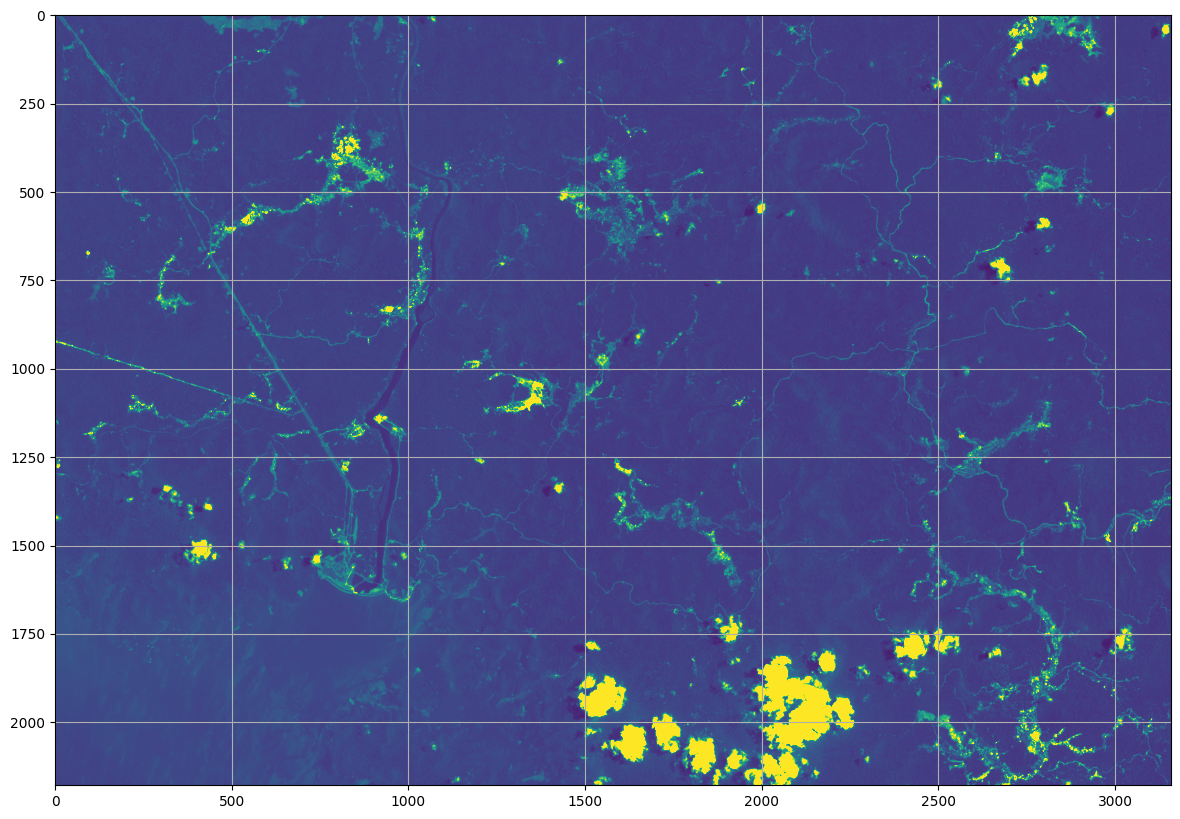

In [25]:
# plot it 
plt.figure(figsize=(15,10))
plt.imshow(b2_arr,vmax=1300)
plt.grid()

In [26]:
def derive_spectral_index(in_bd):
    """
    Function to take a dictionary of data and add new keys
    to the dictionary containing spectral index data that
    the user creates. The user input is to create new 
    keys to 'in_bd' that contain spectral index data
    e.g. 
    
    # simple NIR/VIS ratio
    in_bd['SR'] = in_bd['B8'] / in_bd['B4']
    # no other input is needed    
    
    INPUTS:
        - in_bd (dictionary): a python non-ordered dictionary 
            that is indexes by the spectral bands and in the 
            values.
    """
    
    # USER INPUT!!
    # create your own spectral indexes here.
    # for reference see this library:
    # https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/indexdb/
    in_bd['NDVI'] = (in_bd['B8'] - in_bd['B4']) / (in_bd['B8'] + in_bd['B4'])
    in_bd['NDWI'] = (in_bd['B3'] - in_bd['B8']) / (in_bd['B3'] + in_bd['B8'])    
    in_bd['BSI'] = ((in_bd['B11'] + in_bd['B4']) - \
                    (in_bd['B8'] + in_bd['B2'])) / \
                   ((in_bd['B11'] + in_bd['B4']) + \
                    (in_bd['B8'] + in_bd['B2']))
    
def create_composites(in_arr):
    """
    Function to aggregate a 3d array into a 2d array in the 
    time dimension. Currently only an average is dont here
    but any numpy axis-friendly operation that can handle
    nans can go here. To add a different composite, use
    the numpy function to create a 2d array, then add that
    composite to the returned dictionary with some relevant key 
    e.g.
    min_ar = np.nanmmin(in_arr, axis=0)
    max_ar = np.nanmmax(in_arr, axis=0)
    mu = np.nanmean(in_arr, axis=0)
    return {'min': min_ar, 'max': max_ar, 'mean': mu}    
    """
    
    # USER INPUT!!
    # add your own composites here, like np.nanquantile()
    # np.nanmax, np.nanstd
    # USER INPUT!!

    mu = np.nanmean(in_arr, axis=0)
    
    return {'mean': mu}

In [27]:
# 1=forest, 2 = hydrology and 3 = Non-forest/deforestation.

In [31]:
! readlink -f data_exploration.ipynb

/home/jupyter-user12/data_exploration.ipynb


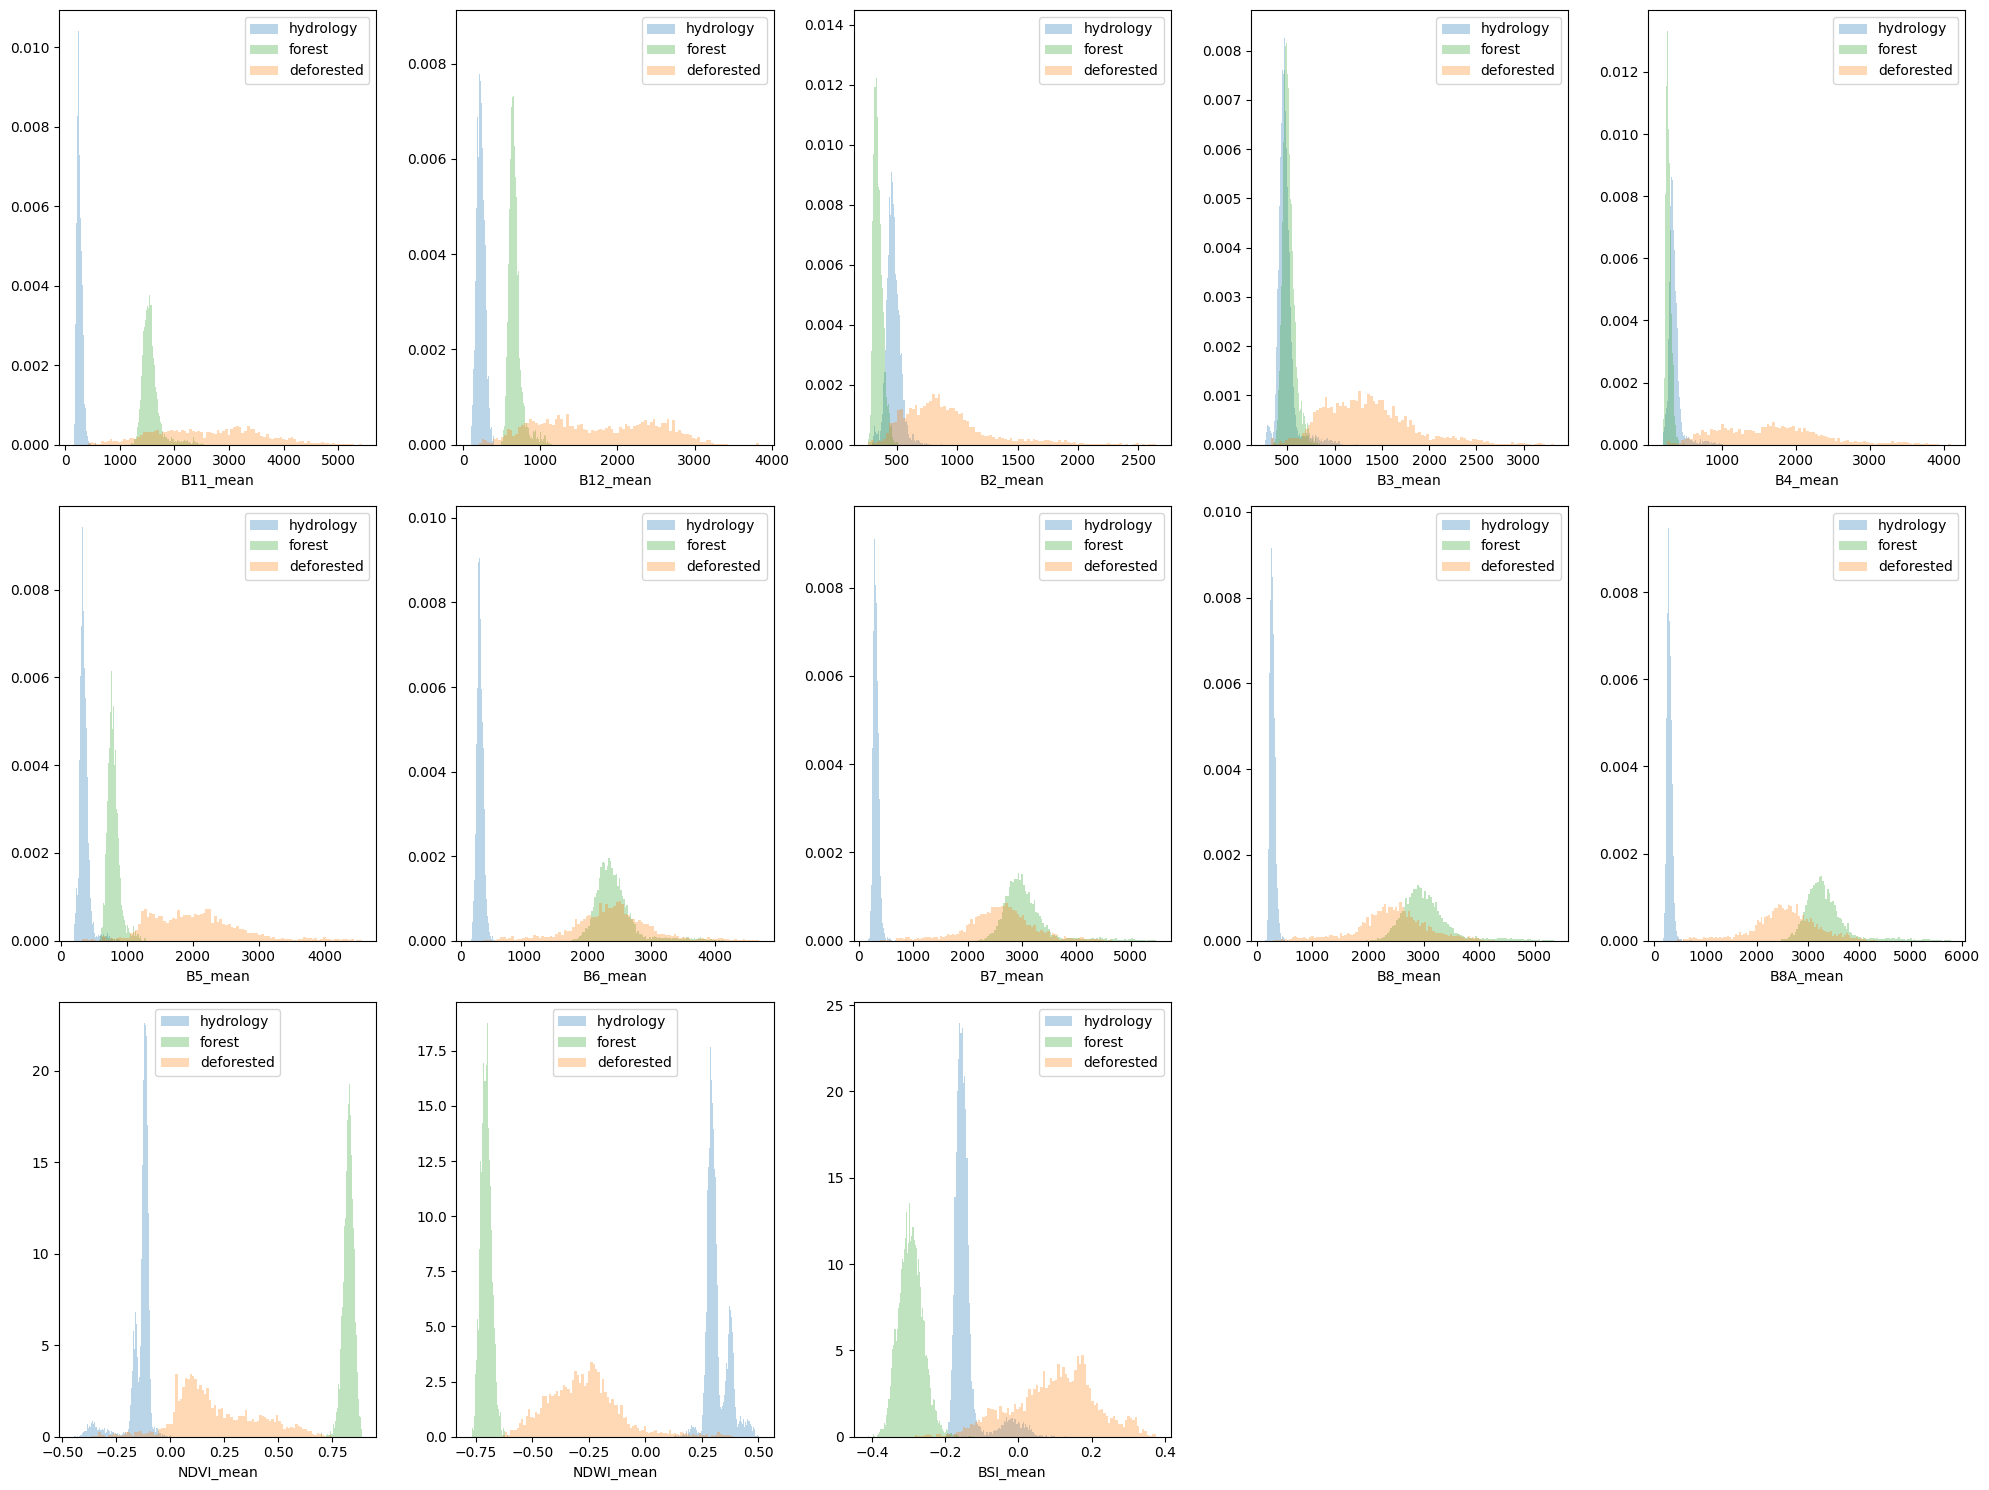

In [29]:
# plot everyting up

# USER INPUT
# if you increase the number of spectral indexes and composites,
# you will have to increase the figure size and number of subplots

fig,axs = plt.subplots(3,5,figsize=(20,15))
axs = np.ravel(axs)

colors = {'hydrology': 'tab:blue', 'forest': 'tab:green', 'deforested': 'tab:orange'}

bands = list(bd['forest'].keys())
for n,band in enumerate(bands):
    for class_name in bd:
        axs[n].hist(bd[class_name][band], bins=100, density=True,alpha=0.3,
                    label=class_name,color=colors[class_name])
        axs[n].set_xlabel(band)
        axs[n].legend()
[i.axis('off') for i in axs[-2:]]
plt.tight_layout()

In [32]:
# create the training dataset

# dictionary to cobvert between text labels and classification values
conv = {'hydrology': 0, 'forest': 1, 'deforested': 2}

# concatenate everything onto axis 1, which is the sample dimension
xa = np.concatenate([np.array(list(bd[i].values())) for i in bd],axis=1).T
# create labels for the training data, which mates the same size as the 
# spectral data
ya = np.concatenate([np.repeat(conv[i], len(bd[i]['B2_mean'])) for i in bd])
xa.shape,ya.shape

# once we are hear, it is the case to simply just repreat what happened in 
# the tutorial

((18819, 13), (18819,))

In [33]:
# setup an array of all possible samples for the training
possible_indexes = np.arange(len(xa))

# find how many samples are 70% of the dataset 
num_in_training = int(len(xa) * 0.7)

# randomly sample 70% of these. 'np.random.choise. will randomly pick 
# a sample size from the array it is given.
training_indexes = np.random.choice(possible_indexes,
                                   num_in_training,
                                   replace=False)

# find the validation samples if they are not in the 
# training_indexes. This uses list comprehension where
# details can be found here:
# https://www.w3schools.com/python/python_lists_comprehension.asp
validation_indexes = np.array([i for i in possible_indexes if 
                                 i not in training_indexes])

In [34]:
# training datasets:
xt = xa[training_indexes]
yt = ya[training_indexes]

# validation datasets:
xv = xa[validation_indexes]
yv = ya[validation_indexes]

print ('Train on: %s, Validate on: %s'%(yt.shape, yv.shape))

Train on: (13173,), Validate on: (5646,)


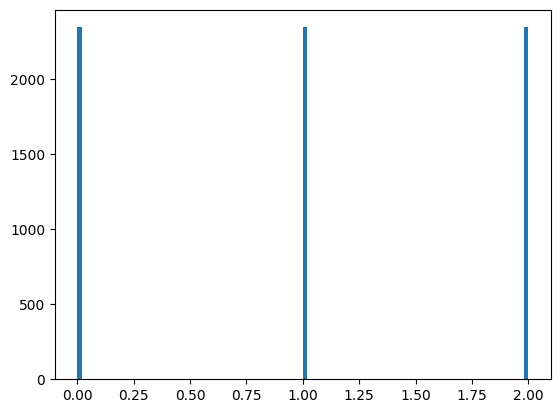

In [35]:
# undersmple water and forest for the mining class
water_idxs = np.where(yt == 0)[0]
forest_idxs = np.where(yt == 1)[0]
mining_idxs = np.where(yt == 2)[0]


water_idxs_undersampled = np.random.choice(water_idxs,
                                            len(mining_idxs),
                                            replace=False)

forest_idxs_undersampled = np.random.choice(forest_idxs,
                                            len(mining_idxs),
                                            replace=False)

all_undersampled_idxs = np.concatenate([water_idxs_undersampled,
                                        forest_idxs_undersampled,
                                        mining_idxs])

# set xt and xt to the undersampled idxs
xt = xt[all_undersampled_idxs]
yt = yt[all_undersampled_idxs]

_ = plt.hist(yt,bins=100)

In [36]:
# import the model libraries
import sklearn.tree
import sklearn.ensemble
import xgboost

In [37]:
# we will set some parameters to limit the classifiers
# and prevent them 'growing too big' or get overfitted
classifier_max_depth = 5
classifier_max_leaf_nodes = 10

# we will train the first model with the following commands
ml_model_v1 = sklearn.tree.DecisionTreeClassifier(max_depth=classifier_max_depth, 
                                                 max_leaf_nodes=classifier_max_leaf_nodes)
ml_model_v1.fit(xt,yt)
# the model is now trained and able to be applied to data.
# lets see what it would predict for the first training point
print ('ML model 1 predicts class:')
print (ml_model_v1.predict(xt[:1]))
print ('Actual class is:')
print (yt[:1])

ML model 1 predicts class:
[0]
Actual class is:
[0]


In [38]:
ml_model_v1_prediction = ml_model_v1.predict(xv)

# we can get a full readout of the performance
# for a full explanation on all the stats, please see:
# https://towardsdatascience.com/a-look-at-precision-recall-and-f1-score-36b5fd0dd3ec
print (sklearn.metrics.classification_report(ml_model_v1_prediction,yv))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2380
           1       1.00      1.00      1.00      2248
           2       1.00      0.99      1.00      1018

    accuracy                           1.00      5646
   macro avg       1.00      1.00      1.00      5646
weighted avg       1.00      1.00      1.00      5646



In [39]:
# you can also get the accuracy score like this
ml_model_v1.score(xv, yv)

0.9985830676585193

In [40]:
feature_names = np.array(list(bd['forest'].keys()))
feature_names

array(['B11_mean', 'B12_mean', 'B2_mean', 'B3_mean', 'B4_mean', 'B5_mean',
       'B6_mean', 'B7_mean', 'B8_mean', 'B8A_mean', 'NDVI_mean',
       'NDWI_mean', 'BSI_mean'], dtype='<U9')

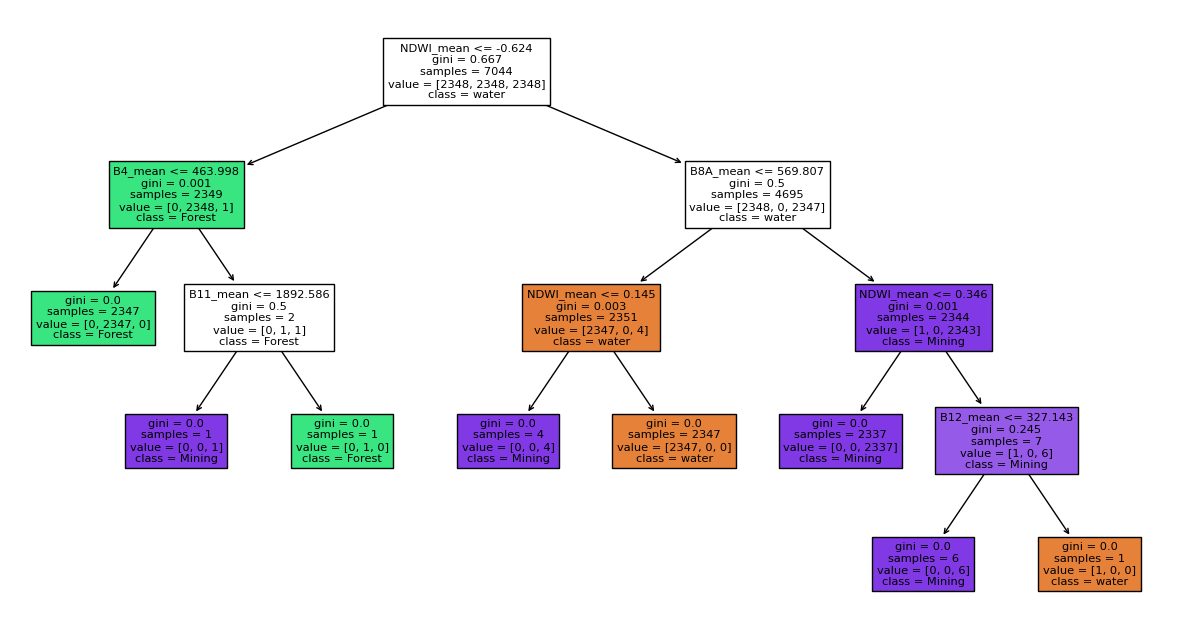

In [41]:
# we can also visualize the decision tree with the sklearn 
# plotting function:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html#sklearn.tree.plot_tree
plt.figure(figsize=(15,8))
_ = sklearn.tree.plot_tree(ml_model_v1, feature_names=feature_names, 
                          filled=True,class_names=['water','Forest', 'Mining'])

In [42]:
ml_model_v3 = xgboost.XGBClassifier()
ml_model_v3.fit(xt,yt)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [43]:
ml_model_v3.score(xv,yv)

0.9991144172865746

## Apply the model to a chunk

In [44]:
def open_chunk_and_classify(xoff,yoff,xsize,ysize):
    
    # get a list of all available files
    flist = sorted(glob.glob('/data/EO4ASGM/EO4ASGM_S2_SR_EO4ASGM_%s*'%year))
    # filter this to exclude the cliudmasking layers    
    band_data_files = [i for i in flist if '%s_B'%year in i]
    band_data = {}

    # open the cloud probability layer     
    cp_opn = gdal.Open([i for i in flist if 'probability' in i][0])
    # open the chunk of cloud probability layer
    cp_arr = cp_opn.ReadAsArray(xsize=xsize,ysize=ysize,xoff=xoff,yoff=yoff)

    # generate the binary cloud mask     
    cm = np.zeros(cp_arr.shape)
    cm[(cp_arr > 20)] = 1
    cm_idx = np.where(cm == 1)

    # close this to save on data
    ma_arr = cp_arr = cp_opn = None

    # create somewhere to put the data 
    band_data = {}
    
    # loop through each file     
    for n,i in enumerate(band_data_files):
        
        # print ('Opening %s, file %s of %s'%(i, n+1, len(band_data_files)))
        
        # open the file in the right arrangement
        opn = reproject_image(i, ma_opn)
        # # open the chunk
        arr = opn.ReadAsArray(xsize=xsize,ysize=ysize,xoff=xoff,yoff=yoff).astype(np.float32,
                                                                                  copy=False)# / 100000
        # mask the clouds
        arr[cm_idx] = np.nan

        # get the band name from the file
        band_name = i.split('_')[-1].replace('.tif','')
        
        band_data[band_name] = arr
        continue
        
        comps = create_composites(arr)
        comp = np.nanmean(arr,axis=0)
        # save the composites         
        band_data[band_name] = comp
        
    # generate indexes from band data
    derive_spectral_index(band_data)
    
    # loop through each of the keys, which include S2 bands and Spectral index bands
    all_comps = {}
    
    for spectral_var in band_data:
        
        comps = create_composites(band_data[spectral_var])        
        for comp_name in comps:
            key_name = '%s_%s'%(spectral_var, comp_name)
            all_comps[key_name] = comps[comp_name]        
    
    # get the shape of the data, so we can transform the data back
    shape = all_comps['B2_mean'].shape
    
    # get all the spectral data bands from the dictionary and cast them 
    # as an array, so the ML model can use it     
    bda = np.array(list(all_comps.values()))
    # reshape the data into a 2D array, reducing the space dimension
    bda = bda.reshape(bda.shape[0], shape[0]*shape[1]).T
    # classifiy the data
    classification_1d = ml_model_v3.predict_proba(bda)
    # reshape the data into a 3d array    
    classification_3d = classification_1d.T.reshape([3,shape[0],shape[1]])
    
    return classification_3d, all_comps

xoff,yoff,xsize,ysize = 500,1250,500,500
output, input_composites = open_chunk_and_classify(xoff,yoff,xsize,ysize)

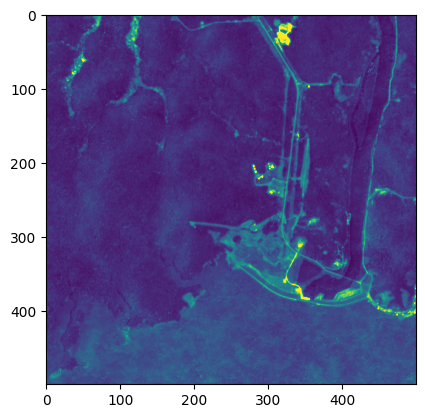

In [45]:
# Quickly visualize one of the input composites
plt.imshow(input_composites['B2_mean'],vmax=1200)

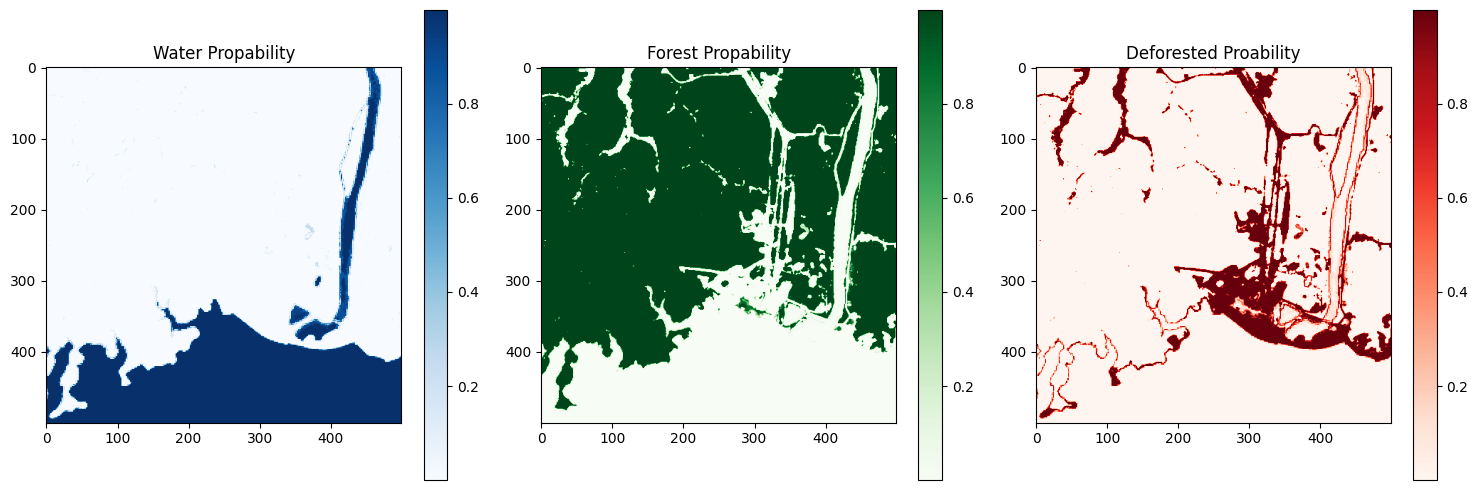

In [46]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
im = axs[0].imshow(output[0],cmap='Blues')
plt.colorbar(im,ax=axs[0])
axs[0].set_title('Water Propability')
im = axs[1].imshow(output[1],cmap='Greens')
plt.colorbar(im,ax=axs[1])
axs[1].set_title('Forest Propability')

im = axs[2].imshow(output[2],cmap='Reds')
plt.colorbar(im,ax=axs[2])
axs[2].set_title('Deforested Proability')

plt.tight_layout()

In [53]:
# create a loop to generate classification by chunks 

# specificy how large you want your chunk size to be
# recomended not to go above 500
chunk_size = 500

# create a regular grid for all the chunks
full_ysize = b2_opn.RasterYSize
full_xsize = b2_opn.RasterXSize
yrng = np.arange(0, full_ysize, chunk_size)
xrng = np.arange(0, full_xsize, chunk_size)

# create an output for the classification, where the first 
# dimension is the probability of the 3 landcover types
full_classification = np.zeros([3, full_ysize, full_xsize])

# USER INPUT
# change this variable to True to run on all chunks
RUN_ON_ALL_CHUNKS = False
# USER INPUT

if RUN_ON_ALL_CHUNKS == False:
    yrng = yrng[-1:]
    xrng = xrng[-1:]

for yi in yrng:
    for xi in xrng:
        
        # find the shape of chunk, where not all chunks will
        # be regular, so this is the easiest way
        chunk_example_size = b2_arr[yi:yi+chunk_size,
                                   xi:xi+chunk_size]        
        
        # create the classifications
        chunk_output, chunk_composites = open_chunk_and_classify(int(xi),int(yi),
                                                                 int(chunk_example_size.shape[1]),
                                                                 int(chunk_example_size.shape[0]))
        
        # put this classification in the indexes of the data 
        full_classification[:,yi:yi+chunk_size,xi:xi+chunk_size] = chunk_output

In [54]:
# finally save the dataset

save_name = 'landcover_full_tile_classification.tif'

# create a lightweight, high cpompression dataset
driver = gdal.GetDriverByName('GTiff')
driver_options = ['COMPRESS=DEFLATE',
                  'BIGTIFF=YES',
                  'PREDICTOR=1',
                  'TILED=YES',
                  'COPY_SRC_OVERVIEWS=YES']

# create the dataset itself 
outRaster = driver.Create(save_name, full_xsize, full_ysize, 3,
                          gdal.GDT_Float32, driver_options)#
# add the same geotransform as the B2 data 
outRaster.SetGeoTransform(b2_opn.GetGeoTransform())
outRaster.SetProjection(b2_opn.GetProjection())

# write the water data
water_band = outRaster.GetRasterBand(1)
water_band.WriteArray(full_classification[0])
water_band.SetMetadata({'description': 'probability of water classification',
                         'units': 'probability'})
water_band.FlushCache()

# write the forest data
forest_band = outRaster.GetRasterBand(2)
forest_band.WriteArray(full_classification[1])
forest_band.SetMetadata({'description': 'probability of forest classification',
                         'units': 'probability'})
forest_band.FlushCache()

# write the deforested data
deforest_band = outRaster.GetRasterBand(3)
deforest_band.WriteArray(full_classification[2])
deforest_band.SetMetadata({'description': 'probability of deforested classification',
                         'units': 'probability'})
deforest_band.FlushCache()

# save everything 
outRaster.FlushCache()
outRaster = None

In [55]:
# check the outputs
output_test_opn = gdal.Open(save_name)
output_test_arr = output_test_opn.ReadAsArray()

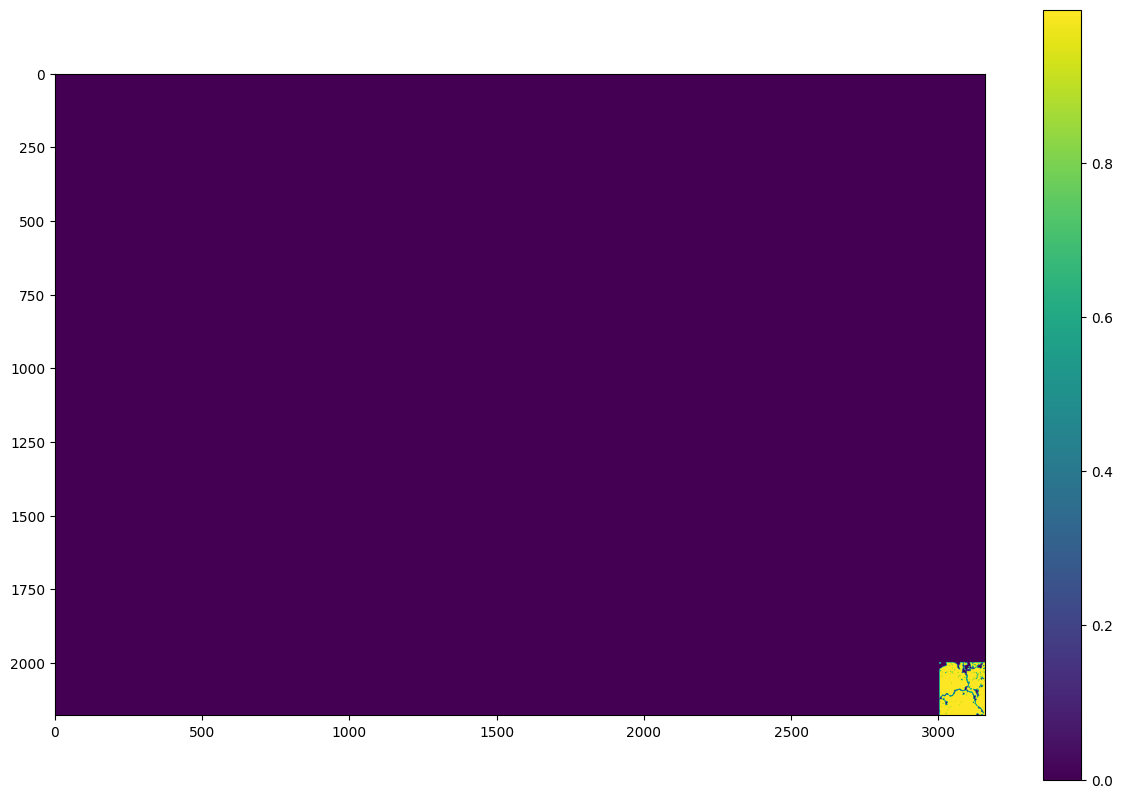

In [58]:
plt.figure(figsize=(15,10))
plt.imshow(output_test_arr[1])
plt.colorbar()

# if 'RUN_ON_ALL_CHUNKS' is False, then the bottom right should be 
# yellow. This represents the probability that that area is forested